# **Лабораторная работа №2 по вычислительной математикe.**

## Работу выполнил: Аль Мажариш Гасем, Б01 - 202а.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

## Параметры

In [2]:
TOLERANCE = 1e-6
MAX_ITER = 100

## Формулировка задачи

Решить уравнение 

$(x - 1)^3 = 3$

* Методом простых итераций
* Методом Ньютона

## Метод простых итераций

In [3]:
def simple_iteration_method(initial_guess, tol, max_iter):
    x = initial_guess
    
    for i in range(max_iter):
        x_new = np.cbrt(3) + 1
        
        if abs(x_new - x) < tol:
            return x_new, i+1
            
        x = x_new
    return x, max_iter

## Метод Ньютона

In [4]:
def newton_method(initial_guess, tol, max_iter):
    x = initial_guess
    
    for i in range(max_iter):
        f_x = (x - 1)**3 - 3
        f_prime_x = 3 * (x - 1)**2
        
        if f_prime_x == 0:
            return None, i+1  # Производная не должна быть равна нулю
            
        x_new = x - f_x / f_prime_x

        if abs(x_new - x) < tol:
            return x_new, i+1
        x = x_new
        
    return x, max_iter

## Тестирование решения

In [5]:
initial_guess = 2

simple_iter_solution, simple_iter_steps = simple_iteration_method(initial_guess, TOLERANCE, MAX_ITER)
newton_solution, newton_steps = newton_method(initial_guess, TOLERANCE, MAX_ITER)

print(f"Метод простых итераций: корень = {simple_iter_solution}, количество итераций = {simple_iter_steps}")
print(f"Метод Ньютона: корень = {newton_solution}, количество итераций = {newton_steps}")

Метод простых итераций: корень = 2.4422495703074083, количество итераций = 2
Метод Ньютона: корень = 2.4422495703074416, количество итераций = 5


## Решение системы нелинейных уравнений

$x_1 = cos(x_2) + 2$

$x_2 = sin(x_3) + 3$

$x_3 = \dfrac{x_1}{2}$

### Определим, можно ли использовать метод простых итераций?

In [6]:
def system_jacobian(x):
    J = np.zeros((3, 3))
    
    J[0][0] = 0
    J[0][1] = -np.sin(x[1])
    J[0][2] = 0

    J[1][0] = 0
    J[1][1] = 0
    J[1][2] = np.cos(x[2])

    J[2][0] = 1/2
    J[2][1] = 0
    J[2][2] = 0

    return J

Видим, что значения якобиана $2\pi$-периодичны, следовательно, проверим значения нормы якобиана на данной области и поймём, является ли отображение сжимающим:

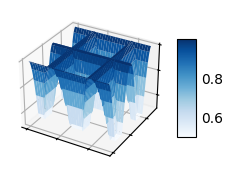

In [7]:
plt.style.use('_mpl-gallery')

X = np.arange(0, 2*np.pi, 0.1)
Y = np.arange(0, 2*np.pi, 0.1)
X, Y = np.meshgrid(X, Y)
Z = np.zeros_like(X)

# Считаем норму Якобиана в множестве точек
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        R = system_jacobian([0, X[i, j], Y[i, j]])
        Z[i, j] = np.linalg.norm(R, ord=2)

# Строим график
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surface = ax.plot_surface(X, Y, Z, cmap='Blues')

fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)

ax.set(xticklabels=[],
       yticklabels=[],
       zticklabels=[])

plt.show()

Как видим, в некоторых точках норма Якобиана отображения принимает значения больше единицы: 


$||J|| > 1$


=> отображения не является сжимающим на R.

**Использовать МПИ нельзя!**

### Использование метода Ньютона

In [8]:
def system_functions(x):
    f1 = np.cos(x[1]) + 2 - x[0]
    f2 = np.sin(x[2]) + 3 - x[1]
    f3 = x[0] / 2 - x[2]
    
    return np.array([f1, f2, f3])

In [9]:
def jacobian(x):
    J = np.zeros((3, 3))
    J[0, 0] = -1
    J[0, 1] = -np.sin(x[1])
    J[0, 2] = 0

    J[1, 0] = 0
    J[1, 1] = -1
    J[1, 2] = np.cos(x[2])

    J[2, 0] = 0.5
    J[2, 1] = 0
    J[2, 2] = -1

    return J

In [10]:
def system_newton_method(x0, tol, max_iter):
    x = np.array(x0)
    greater = True
    iters = 0
    
    while greater:
        iters += 1

        # Находим вектор функций и Якобиан
        F = system_functions(x)
        J = jacobian(x)
        
        # Проверка сходимости
        greater = np.linalg.norm(F) > tol
        if iters > max_iter:
            greater = False

        # Решение линейной системы для вычисления приращения
        delta_x = np.linalg.solve(J, -F)

        # Обновление приближения
        x = x + delta_x

        # Проверка на сходимость
        greater = np.linalg.norm(delta_x) > tol
    
    return x, iters

In [11]:
system_guess = [1, 1, 1]

system_solution, system_steps = system_newton_method(system_guess, TOLERANCE, MAX_ITER)

print(f"Решение системы методом Ньютона: корень = {system_solution}, количество итераций = {system_steps}")

Решение системы методом Ньютона: корень = [1.06649942 3.50833454 0.53324971], количество итераций = 5


## Неожиданный результат

Случайно было замечено, что МПИ даёт правильный ответ для данной системы. Сначала этот факт сбил меня с толку. Но всё же то, что отображение не является сжимающим не значит, что МПИ не сработает, это значит лишь то, что МПИ не гарантирует верный результат. В данном случае повезло с начальными данными (на самом деле мне так и не удалось подобрать такие начальные данные, чтобы МПИ не сработал), с тем, что система "псевдосжимающая" и другими факторами.

In [12]:
def system_iter_method(x, tol, max_iter):
    x_new = x.copy()
    greater = True
    iters = 0
    
    while greater:
        iters += 1
        
        x_new[0] = float(np.cos(x[1]) + 2)
        x_new[1] = float(np.sin(x[2]) + 3)
        x_new[2] = float(x[0] / 2)

        greater = np.linalg.norm(np.array(x_new) - np.array(x)) > tol
        if iters > max_iter:
            greater = False
            
        x = x_new.copy()
        
    return x_new, iters

SIM_guess = [0, np.pi/2, np.pi/2]

system_solution_SIM, system_steps_SIM = system_iter_method(SIM_guess, TOLERANCE, MAX_ITER)
print(f"Решение системы МПИ: корень = {system_solution_SIM}, количество итераций = {system_steps_SIM}")

Решение системы МПИ: корень = [1.0664998004922386, 3.5083348226111872, 0.5332496529847207], количество итераций = 25
